In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [18]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()
df = pd.DataFrame(cursor.execute("""select * from combined5""").fetchall())
df.columns = [description[0] for description in cursor.description]
df = df.drop(columns=["index", "level_0"])
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,plant_name_gen,operator_name_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month_nerc,number_affected,disturbance_events
0,5.4,23.100,NaN,0.49,NaN,IMP,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,NaN,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,259412,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
1,5.7,22.800,NaN,0.48,NaN,IMP,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,NaN,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,52241,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
2,0.0,1.039,NaN,0.00,NaN,None,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-1-SERC,0.0,0.0
3,0.0,1.039,NaN,0.00,NaN,None,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-1-SERC,0.0,0.0
4,0.0,1.039,NaN,0.00,NaN,None,None,None,None,None,C,NG,863.1,Natural Gas,NaN,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-1-SERC,0.0,0.0


In [3]:
ng_fields = [ 'contract_type', 'fuel_cost', 'natural_gas_delivery_contract_type', 'natural_gas_supply_contract_type', 'natural_gas_transportation_service', 'operator_id',  'plant_id', 'plant_state', 'primary_transportation_mode', 'purchase_type', 'quantity', 'regulated', "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "mmbtu_per_unit_gen", "disturbance_events", "number_affected"]

# Checking Correlations

In [6]:
# Label encode categorical fields so that they can be correlated
df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_ng[ng_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_ng[not_encode].reset_index()
temp2 = df_ng[to_encode].apply(le.fit_transform).reset_index()
df_ng = temp1.merge(temp2, on="index").set_index("index")

In [7]:
corr = df_ng.corr()

In [8]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['natural_gas_delivery_contract_type',
  'natural_gas_supply_contract_type',
  0.9949670257245146],
 ['natural_gas_supply_contract_type',
  'natural_gas_delivery_contract_type',
  0.9949670257245146],
 ['disturbance_events', 'number_affected', 0.7655082998226197],
 ['number_affected', 'disturbance_events', 0.7655082998226197],
 ['mmbtu_per_unit_gen', 'reported_prime_mover', 0.4551813724903194],
 ['natural_gas_transportation_service', 'purchase_type', 0.375298202366619],
 ['purchase_type', 'natural_gas_transportation_service', 0.375298202366619],
 ['contract_type', 'natural_gas_delivery_contract_type', 0.35006057060938583],
 ['natural_gas_delivery_contract_type', 'contract_type', 0.35006057060938583],
 ['contract_type', 'natural_gas_supply_contract_type', 0.34927582099496446],
 ['natural_gas_supply_contract_type', 'contract_type', 0.34927582099496446],
 ['primary_transportation_mode', 'purchase_type', 0.2942462825380524],
 ['purchase_type', 'primary_transportation_mode', 0.294246282538

Some obvious correlations in here, like gas supply and delivery contract type or disturbance events and number affected (by disturbance events). It helps give an idea of the data, btu it doesn't indicate any changes to features.

### Checking Correlations Involving Fuel Cost

In [9]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'number_affected', 0.016547105838107864],
 ['fuel_cost', 'regulated', nan],
 ['number_affected', 'fuel_cost', 0.016547105838107864],
 ['fuel_cost', 'disturbance_events', 0.008163806819898293],
 ['disturbance_events', 'fuel_cost', 0.008163806819898293],
 ['fuel_cost', 'reporting_frequency', 0.005495275823372207],
 ['reporting_frequency', 'fuel_cost', 0.005495275823372207],
 ['fuel_cost', 'nerc_region', 0.00423735556784291],
 ['nerc_region', 'fuel_cost', 0.00423735556784291],
 ['fuel_cost', 'plant_id', 0.003095974637123335],
 ['plant_id', 'fuel_cost', 0.003095974637123335],
 ['fuel_cost', 'primary_transportation_mode', 0.002930004254140046],
 ['primary_transportation_mode', 'fuel_cost', 0.002930004254140046],
 ['fuel_cost', 'supplier', 0.00274519529513206],
 ['supplier', 'fuel_cost', 0.00274519529513206],
 ['fuel_cost', 'natural_gas_supply_contract_type', 0.0006275626240884574],
 ['natural_gas_supply_contract_type', 'fuel_cost', 0.0006275626240884574],
 ['fuel_cost', 'natu

Interesting that disturbance events and number affected are correlated to fuel cost, but the correlation is not high. Same for other correlations: interesting but not strong enough to infer anything. On to modelling.

# Modelling

In [3]:

df_ng = df[df["fuel_group"] == "Natural Gas"][ng_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_ng[ng_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
temp1 = df_ng[not_encode].reset_index()
temp2 = pd.get_dummies(df_ng[to_encode]).reset_index()
df_ng = temp1.merge(temp2, on="index").set_index("index")

In [146]:
X = df_ng.drop(columns=["fuel_cost"])
y = (df_ng.fuel_cost > df_ng.fuel_cost.quantile(.9))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [149]:
model = DecisionTreeClassifier(random_state=23)
results = model.fit(X_train, y_train)


In [150]:
results.score(X_test, y_test)

0.9493211152707157

In [151]:
cross_val_score(results, X, y, cv=5)

array([0.46182787, 0.87096534, 0.90033711, 0.88595854, 0.88601229])

In [152]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.41363004016080623
plant_id 0.0713917231275164
primary_transportation_mode_PL 0.045662009500960075
mmbtu_per_unit_gen 0.04450722542000971
number_affected 0.01678085025869923
operator_id_19876.0 0.010048086071635369
operator_id_16534.0 0.009845627609527044
operator_id_16572.0 0.009595297508235833
nerc_region_SPP 0.009586190988073787
purchase_type_N/A 0.009371929392257046
disturbance_events 0.008481261145606243
supplier_VARIOUS 0.00829040315056773
natural_gas_transportation_service_F 0.007485496010826452
contract_type_S 0.007369196063739356
reporting_frequency_M 0.006768845930993168
nerc_region_NPCC 0.006169875340367029
nerc_region_MRO 0.00568244001320312
supplier_LG&E 0.005518598160978308
contract_type_C 0.0048545605825934535
supplier_BPE 0.004821543197242378
reported_prime_mover_GT 0.004460981611285116
nerc_region_FRCC 0.004286813272566593
natural_gas_transportation_service_I 0.00404422327967339
supplier_MUNIGAS - BP ENERGY 0.004009497231895011
operator_id_11249.0 0.003972742

operator_id_11740.0 0.0
operator_id_12524.0 0.0
operator_id_12647.0 0.0
operator_id_12927.0 0.0
operator_id_13228.0 0.0
operator_id_13407.0 0.0
operator_id_13488.0 0.0
operator_id_13809.0 0.0
operator_id_14077.0 0.0
operator_id_14127.0 0.0
operator_id_14194.0 0.0
operator_id_14232.0 0.0
operator_id_14268.0 0.0
operator_id_14605.0 0.0
operator_id_15472.0 0.0
operator_id_15776.0 0.0
operator_id_16088.0 0.0
operator_id_16183.0 0.0
operator_id_16295.0 0.0
operator_id_1692.0 0.0
operator_id_17609.0 0.0
operator_id_17697.0 0.0
operator_id_17874.0 0.0
operator_id_18445.0 0.0
operator_id_189.0 0.0
operator_id_19558.0 0.0
operator_id_19728.0 0.0
operator_id_20421.0 0.0
operator_id_20858.0 0.0
operator_id_22053.0 0.0
operator_id_23279.0 0.0
operator_id_24431.0 0.0
operator_id_2548.0 0.0
operator_id_26253.0 0.0
operator_id_30151.0 0.0
operator_id_3522.0 0.0
operator_id_39347.0 0.0
operator_id_40582.0 0.0
operator_id_40613.0 0.0
operator_id_40614.0 0.0
operator_id_4363.0 0.0
operator_id_4716.0 0.0

In [30]:
y_pred = results.predict(X_test)

In [31]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))

In [32]:
conf

,0,1
0,47967,306
1,4502,916


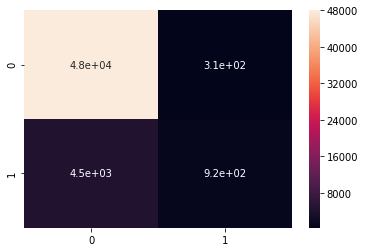

In [33]:
sns.heatmap(conf, annot=True)

In [34]:
f1_score(y_test, y_pred)

0.2759036144578313

While score is good, f1-score is terrible. Because the data is imbalanced - few price spikes overall - need to use SMOTE to account.

In [136]:
# Show imbalance of data
len(df_ng[df_ng.fuel_cost > df_ng.fuel_cost.quantile(.9)])/len(df_ng)

0.09997988482198067

# Modelling with SMOTE

In [173]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2)

In [174]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [175]:
y_pred = results.predict(X_test)

In [176]:
f1_score(y_test, y_pred)

0.859567223198594

Much better F1-score. But let's see if we can improve.

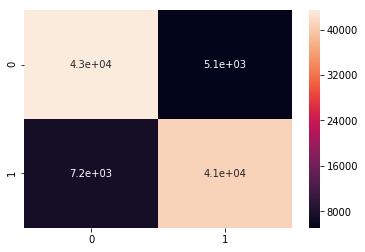

In [40]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [42]:
conf

,0,1
0,43376,5112
1,7231,40927


In [41]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

purchase_type_N/A 0.2799305828141
primary_transportation_mode_PL 0.07928082279993348
reported_prime_mover_GT 0.07184211463895088
contract_type_N/A 0.06718664238361852
reported_prime_mover_CT 0.06708855177363116
operator_id_16534.0 0.05420646565799079
primary_transportation_mode_N/A 0.05362530537563987
reporting_frequency_A 0.05090233171439193
quantity 0.04462028261507721
reported_prime_mover_CA 0.0351246197887928
reported_prime_mover_ST 0.02859605804556457
supplier_VARIOUS 0.021910232392130496
mmbtu_per_unit_gen 0.011873009741851842
plant_id 0.011128545875214193
number_affected 0.009897761099937607
nerc_region_SPP 0.009260532782398617
plant_state_AZ 0.008343999122734444
plant_state_VA 0.005680729730602374
natural_gas_transportation_service_I 0.0056406480111331455
plant_state_WA 0.005545549702925694
contract_type_S 0.005389232556217691
operator_id_19876.0 0.005311115719079142
supplier_VARIOUS (NATURAL GAS SPOT PURCHASES ONLY) 0.004812623326551191
nerc_region_MRO 0.0040960376249761345
op

supplier_FLORIDA GAS TRANSMISSION 0.0
supplier_FLORIDA GAS UTILITY 0.0
supplier_FLORIDA POWER & LIGHT 0.0
supplier_FORTIS ENERGY 0.0
supplier_FORTIS ENERGY MARKETING & TRADING GP 0.0
supplier_FREEPOINT COMMODITIES LLC 0.0
supplier_FURIE OPERATING ALASKA, LLC 0.0
supplier_GAS COMPANY OF NEW MEXICO 0.0
supplier_GASEARCH 0.0
supplier_GAZPROM MT 0.0
supplier_GOLDMAN SACHS 0.0
supplier_GORDONSVILLE 0.0
supplier_GREEN PLAINS TRADE GROUP LLC 0.0
supplier_GULF SOUTH PIPELINE, LP 0.0
supplier_GULF STREAM 0.0
supplier_GULFSOUTH PIPELINE 0.0
supplier_GUNVOR USA LLC 0.0
supplier_Gavilon 0.0
supplier_Gulf South 0.0
supplier_HESS 0.0
supplier_HESS ENERGY 0.0
supplier_HIGH PLAINS BIOENERGY,LLC 0.0
supplier_HILCORP ENERGY CO 0.0
supplier_HOUSTON PIPE LINE 0.0
supplier_HOUSTON PIPELINE COMPANY 0.0
supplier_HPL 0.0
supplier_HUSKY ENERGY 0.0
supplier_HYDROCARBON EXCHANGE CORP 0.0
supplier_Hess Corp 0.0
supplier_IBERDROLA RENEWABLES 0.0
supplier_IBERDROLA RENEWABLES CANADA 0.0
supplier_IDAHO POWER 0.0
sup

# Analyze False Positives and Negatives

In [153]:
y_pred = results.predict(X)

In [154]:
wrongs = (y_pred != y)

In [155]:
df_ng["wrong"] = wrongs

In [156]:
df_ng[df_ng["wrong"] == True]["natural_gas_delivery_contract_type_N/A"].value_counts()

1    2796
0     173
Name: natural_gas_delivery_contract_type_N/A, dtype: int64

Large number of incorrect values are specified as N/A for delivery contract. Maybe we can subset the data of those values and use a separate model.

## Subsetting the data - Where Delivery Contract != N/A

In [157]:
df_ng2 = df_ng[(df_ng["natural_gas_delivery_contract_type_N/A"] != 1)].drop(columns="wrong")

In [158]:
X = df_ng2.drop(columns="fuel_cost")
y = (df_ng2.fuel_cost > df_ng.fuel_cost.quantile(.9))

In [159]:
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2)

In [160]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [161]:
y_pred = results.predict(X_test)

In [162]:
f1_score(y_test, y_pred)

0.9345666324083591

Even better F1-score on the subset.

In [163]:
leaf1_test = y_test
leaf1_pred = y_pred

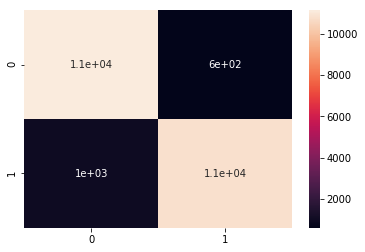

In [74]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [75]:
conf

,0,1
0,11123,604
1,995,10808


In [97]:
cross_val_score(results, X_res, y_res, cv=5)

array([0.92150446, 0.94759881, 0.93289418, 0.93574161, 0.94376913])

No abberations in cross_val_score

# Modeling Subset of Data - Delivery Contract == N/A

In [164]:
df_ng3 = df_ng[(df_ng["natural_gas_delivery_contract_type_N/A"] == 1)].drop(columns="wrong")

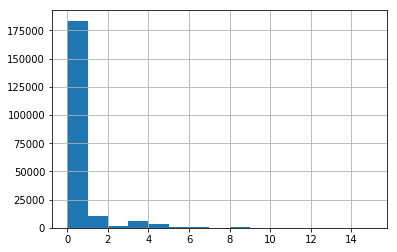

In [119]:
df_ng3.number_affected.hist(bins=int(df_ng3.number_affected.max()))

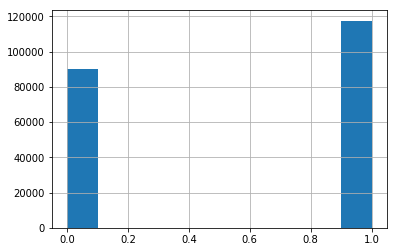

In [120]:
df_ng3.contract_type_S.hist()

In [165]:
X = df_ng3.drop(columns="fuel_cost")
y = (df_ng3.fuel_cost > df_ng.fuel_cost.quantile(.9))
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size = 0.2)

In [166]:
model = DecisionTreeClassifier()
results = model.fit(X_train, y_train)

In [167]:
y_pred = results.predict(X_test)
f1_score(y_pred, y_test)

0.9434013903333517

Great, good F1-Score on the other subset as well.

In [168]:
leaf2_pred = y_pred
leaf2_test = y_test

In [132]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

quantity 0.14565889040545613
mmbtu_per_unit_gen 0.062097259541437536
primary_transportation_mode_N/A 0.05234876512955381
primary_transportation_mode_PL 0.051800235682300744
reported_prime_mover_CT 0.04863319086025437
reported_prime_mover_GT 0.03682300270342701
contract_type_N/A 0.03643100418063004
reported_prime_mover_CA 0.03457390083565697
plant_id 0.030283570753951817
contract_type_S 0.023628413410926342
reported_prime_mover_ST 0.02174290151274531
purchase_type_N/A 0.018925621444395715
purchase_type_S 0.01669699379813102
number_affected 0.015211113945835917
natural_gas_transportation_service_I 0.01245963412467119
natural_gas_transportation_service_F 0.012251628573515982
operator_id_16534.0 0.011755623984133679
contract_type_C 0.010311710917924127
disturbance_events 0.009915263343737473
plant_state_NY 0.009690629903570568
nerc_region_SERC 0.009661027888615838
reporting_frequency_M 0.009225886640562028
nerc_region_SPP 0.008205743288526681
reporting_frequency_A 0.00818225418014039
plant

supplier_ALLIANT ENERGY 7.865090934238617e-05
supplier_J. ARON AND COMPANY 7.825877946245326e-05
operator_id_12647.0 7.790632555974859e-05
supplier_Energy Transfer 7.723893018027079e-05
supplier_CPEnergySv 7.661292461462037e-05
operator_id_16088.0 7.603071028006324e-05
supplier_BG LNG SERVICES 7.54422411088936e-05
operator_id_3258.0 7.540297821615441e-05
supplier_INFINITE ENERGY 7.44040874863528e-05
operator_id_17697.0 7.425598903440487e-05
supplier_DISTR ENSTAR NATURAL GAS 7.387752320588705e-05
supplier_MICHIGAN GAS UTILITIES 7.367487972449212e-05
supplier_AMEREN UE 7.290239778287714e-05
supplier_NEW JERSEY NATURAL GAS 7.226013961363997e-05
supplier_YAKA ENERGY 7.208039244956971e-05
operator_id_9191.0 7.1582014424942e-05
supplier_CORAL CANADA-USA 7.148356774984602e-05
operator_id_1307.0 7.038464522861806e-05
supplier_ALLIANT 7.036605399598396e-05
supplier_SUPERIOR NAT GAS 7.010494793924287e-05
supplier_TWIN EAGLE RESOURCE MANAGEMENT 7.001241496509802e-05
operator_id_9267.0 6.972059488

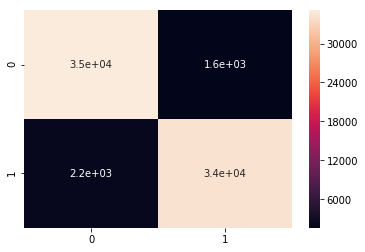

In [137]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [138]:
conf

,0,1
0,35123,1591
1,2173,34229


# Combine the Two Leafs to Find Out Combined F1 Score

In [171]:
leaf1_pred = pd.DataFrame(leaf1_pred)
leaf2_pred = pd.DataFrame(leaf2_pred)
leaf1_test = pd.DataFrame(leaf1_test)
leaf2_test = pd.DataFrame(leaf2_test)



leafs_pred = leaf1_pred.append(leaf2_pred)
leafs_test = leaf1_test.append(leaf2_test)

In [172]:
f1_score(leafs_pred, leafs_test)

0.9412618741444394